<h1 >Summary</h1>

1. [Introduction](#section_1)      
2. [Data Cleaning](#section_2)      
3. [Data Visualization](#section_3)      
4. [Modeling](#section_4)     
5. [Conclusion](#section_5)      


#  <span id="section_1">Introduction</span>


The goal of this notebook is to predict whether a novice player in the NBA would have a career lasting more than 5 years or not, based on their statistics. This prediction will help decide if it's wise to invest in this player.

In [3]:
# Data Manipulation and Visualization Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

%matplotlib inline

# Modeling Libraries
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb

# Ensemble Modeling
from sklearn.ensemble import VotingClassifier, StackingClassifier

# Model Selection and Hyperparameter Tuning
import optuna

# Joblib for Model Serialization
from joblib import dump, load

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')


In [4]:
# Set display options to show all columns of a dataframe without truncation
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Set the logging level to WARNING for Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

#plot style
plt.style.use("ggplot")

# Set the seed
seed_value = 42
np.random.seed(seed_value)

In [5]:
#load data
data=pd.read_csv('./nba_logreg.csv')

In [6]:
data.head()

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,1.6,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,2.6,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,0.9,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,0.9,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,1.3,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0


In [7]:
print(f'Shape of data is :  {data.shape}')

Shape of data is :  (1340, 21)


In [8]:
data.dtypes

Name            object
GP               int64
MIN            float64
PTS            float64
FGM            float64
FGA            float64
FG%            float64
3P Made        float64
3PA            float64
3P%            float64
FTM            float64
FTA            float64
FT%            float64
OREB           float64
DREB           float64
REB            float64
AST            float64
STL            float64
BLK            float64
TOV            float64
TARGET_5Yrs    float64
dtype: object

In [9]:
# Show quantiles of each column
data.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
count,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1329.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000
mean,60.414179,17.624627,6.801493,2.629104,5.885299,44.169403,0.247612,0.779179,19.308126,1.297687,1.821940,70.300299,1.009403,2.025746,3.034478,1.550522,0.618507,0.368582,1.193582,0.620149
std,17.433992,8.307964,4.357545,1.683555,3.593488,6.137679,0.383688,1.061847,16.022916,0.987246,1.322984,10.578479,0.777119,1.360008,2.057774,1.471169,0.409759,0.429049,0.722541,0.485531
min,11.000000,3.100000,0.700000,0.300000,0.800000,23.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.300000,0.000000,0.000000,0.000000,0.100000,0.000000
25%,47.000000,10.875000,3.700000,1.400000,3.300000,40.200000,0.000000,0.000000,0.000000,0.600000,0.900000,64.700000,0.400000,1.000000,1.500000,0.600000,0.300000,0.100000,0.700000,0.000000
50%,63.000000,16.100000,5.550000,2.100000,4.800000,44.100000,0.100000,0.300000,22.400000,1.000000,1.500000,71.250000,0.800000,1.700000,2.500000,1.100000,0.500000,0.200000,1.000000,1.000000
75%,77.000000,22.900000,8.800000,3.400000,7.500000,47.900000,0.400000,1.200000,32.500000,1.600000,2.300000,77.600000,1.400000,2.600000,4.000000,2.000000,0.800000,0.500000,1.500000,1.000000
max,82.000000,40.900000,28.200000,10.200000,19.800000,73.700000,2.300000,6.500000,100.000000,7.700000,10.200000,100.000000,5.300000,9.600000,13.900000,10.600000,2.500000,3.900000,4.400000,1.000000


#  <span id="section_2">Data Cleaning</span>


In [10]:
#missing values
data.isnull().sum()

Name            0
GP              0
MIN             0
PTS             0
FGM             0
FGA             0
FG%             0
3P Made         0
3PA             0
3P%            11
FTM             0
FTA             0
FT%             0
OREB            0
DREB            0
REB             0
AST             0
STL             0
BLK             0
TOV             0
TARGET_5Yrs     0
dtype: int64

We notice that all columns, except for the 3P% column (3PointsAttempts), do not have any missing values. The 3P% column has 11 missing values, representing approximately 0.8% of the total data. We will replace these NaN values with zero, as mentioned in the statement.

In [11]:
#fill nans with zeros.
data['3P%'] = data['3P%'].fillna(0)

Let's examine the potential presence of duplicates in the data.

In [12]:
def remove_duplicates_and_count(df):
    # Count the number of duplicates in the DataFrame
    duplicate_count = df.duplicated().sum()

    # Keep only the first occurrence of each duplicate group
    df_no_duplicates = df.drop_duplicates(keep='first')

    # Optionally, you can reset the index if needed
    df_no_duplicates.reset_index(drop=True, inplace=True)

    return df_no_duplicates, duplicate_count


data, duplicate_count = remove_duplicates_and_count(data)


print("\nThe number of deleted duplicates is:", duplicate_count)



The number of deleted duplicates is: 12


Now let's examine the duplicates in the 'Name' column.

In [13]:
def check_duplicates(df, column):
    duplicates = df.duplicated(subset=[column])
    if duplicates.any():
        print(f"Duplicates found in column '{column}':")
        print(df[duplicates][column])
        return list(df[duplicates][column])
    else:
        print(f"No duplicates found in column '{column}'.")
        return None

duplicates_name = check_duplicates(data, 'Name')


Duplicates found in column 'Name':
19         Larry Johnson
72             Dee Brown
73             Dee Brown
74             Dee Brown
121         Tim Hardaway
127            Glen Rice
157        Michael Smith
158        Michael Smith
159        Michael Smith
163        Charles Smith
164        Charles Smith
165        Charles Smith
166        Charles Smith
167        Charles Smith
195     Michael Anderson
206          Mark Bryant
221           Mark Davis
222           Mark Davis
223           Mark Davis
308           Bob Martin
360        Charles Jones
361        Charles Jones
362        Charles Jones
454          Jeff Taylor
466       Walker Russell
546           Larry Drew
558        James Johnson
759       Cory Alexander
839          Bobby Jones
861            David Lee
950        Carlos Rogers
1083         Jamie Feick
1116    Cedric Henderson
1219      Glenn Robinson
Name: Name, dtype: object


This is interesting, we have several duplicates in the player names. Let's examine them case by case!

After checking duplicates for each name, we've identified two distinct scenarios. In the first case, duplicates with the same name have identical statistics but different target value. In the second case, duplicates have different statistics and the same target value. To illustrate these two categories, here's an example of each scenario:

In [14]:
#first case
data[data.Name == "Larry Johnson"]

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
18,Larry Johnson,82,37.2,19.2,7.5,15.3,49.0,0.1,0.3,22.7,4.1,5.0,82.9,3.9,7.0,11.0,3.6,1.0,0.6,1.9,0.0
19,Larry Johnson,82,37.2,19.2,7.5,15.3,49.0,0.1,0.3,22.7,4.1,5.0,82.9,3.9,7.0,11.0,3.6,1.0,0.6,1.9,1.0


In terms of modeling, these elements could cause disruptions in the model's learning process and limit its ability to generalize effectively. Moreover, since all the statistics are identical, it's highly probable that they were gathered almost simultaneously, most likely in the same year. Consequently, seeing the changing target value makes it impossible to determine if the player indeed had a career of more than 5 years based on the year the statistics were collected. In this case, it would be preferable to remove these examples from the dataset.

In [15]:
#second case
data[data.Name == "Michael Anderson"]

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
194,Michael Anderson,36,20.3,5.7,2.0,4.9,41.7,0.0,0.2,14.3,1.6,2.3,69.5,1.2,1.3,2.5,4.3,1.2,0.1,2.3,0.0
195,Michael Anderson,65,18.5,7.4,2.9,5.8,50.1,0.0,0.1,0.0,1.5,2.7,57.1,1.8,2.7,4.5,1.0,1.0,0.3,1.2,0.0


For the examples in the second scenario, nothing abnormal has been detected. For instance, it's entirely possible that a player had a career of only two years (for example, from 2020 to 2021), resulting in a null target value for those two years. This situation is entirely plausible and doesn't require any specific action.

In [16]:
# let's delete elements of first case

second_case_names=["Michael Anderson","Mark Bryant","Bob Martin","Jeff Taylor","James Johnson","Cory Alexander",
                   "Carlos Rogers","Jamie Feick"]
first_case_names= list(set(duplicates_name)-set(second_case_names))

#delete all elements of first case
data = data[~data['Name'].isin(first_case_names)]

In [17]:
data.shape

(1288, 21)

#  <span id="section_3">Data Visualization</span>


In this section, we will undertake various visual analyses to better understand the data and extract the maximum information for later use in modeling the problem.

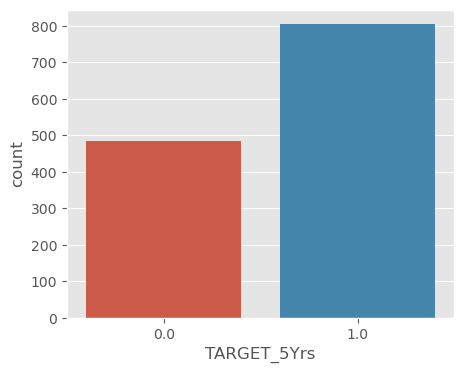

In [18]:
plt.figure(figsize=(5, 4))
sns.countplot(data=data,x='TARGET_5Yrs')
plt.show()


Class 0 contains 484 elements, representing approximately 37.5% of the total dataset, while class 1 has 804 elements, equivalent to about 62.5% of the data. Thus, we observe a slight data imbalance, where class 1 is more represented than class 0

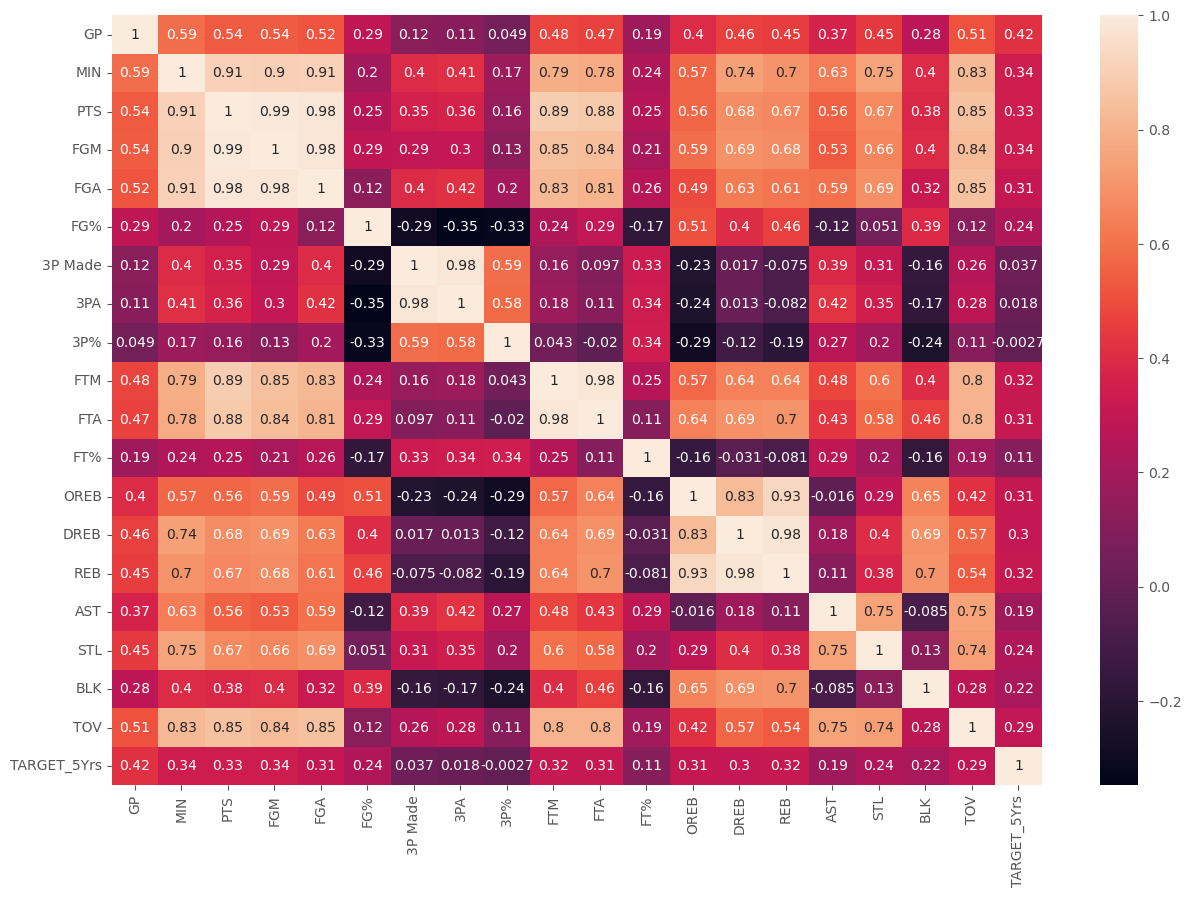

In [19]:
plt.figure(figsize=(15, 10))
sns.heatmap(data.corr(),annot=True)
plt.show()

(Pearson correlation is used)

Observations:

* Some features are strongly positively correlated, for example, MIN (minutes played) and TOV (turnovers) with a correlation coefficient of 0.83. It might be feasible to eliminate one of the two during model training as they provide similar information.

* Some features show a slight negative correlation, such as 3PA (3-point attempts) and FG% (field goal percentage) with a coefficient of -0.35. This suggests that as the number of 3-point attempts increases, the success percentage slightly decreases.

* Other features do not exhibit significant correlation with each other, for instance, 3P MADE (3-pointers made) and DREB (defensive rebounds) with a correlation coefficient of 0.017. These features seem to provide distinct information and could be interesting for the model.

It's important to note that the target variable has not been included in this correlation analysis as it focuses solely on relationships between continuous features.

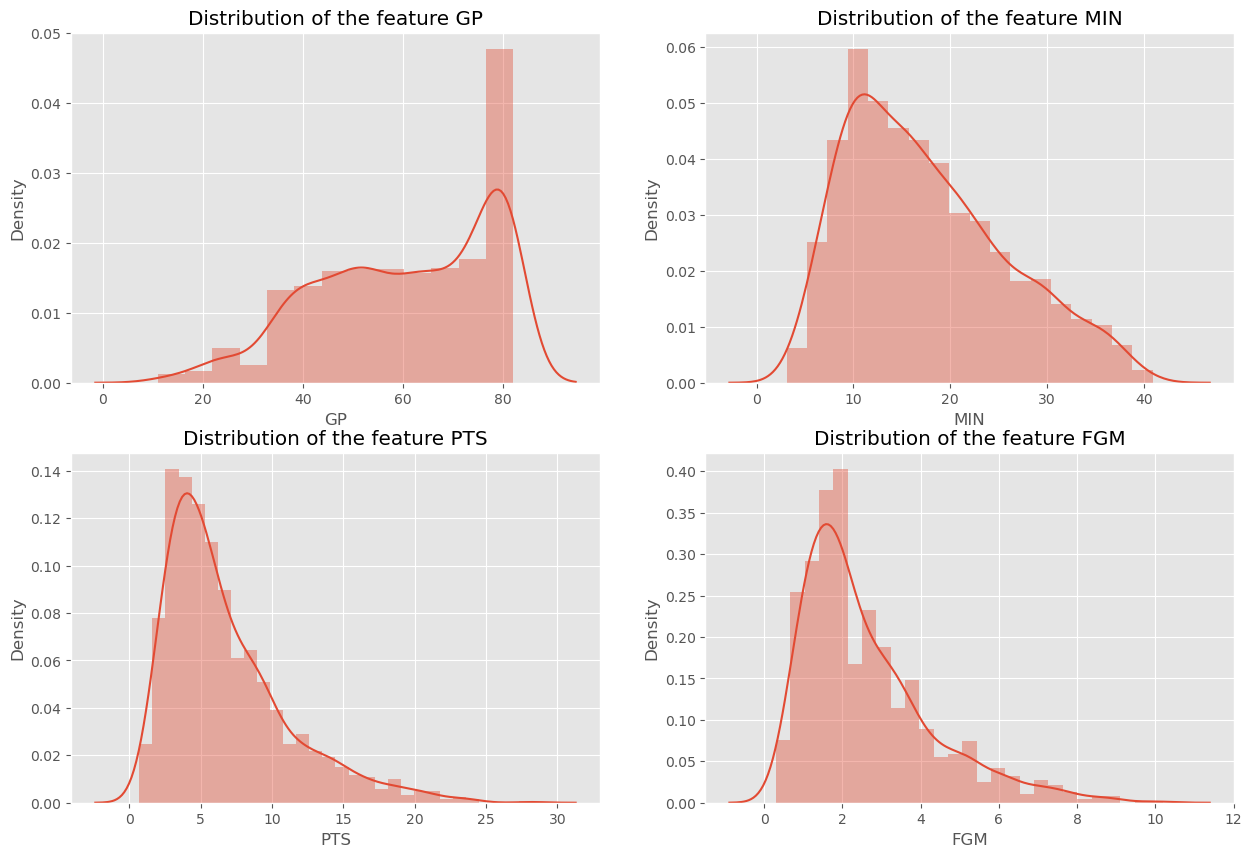

In [20]:
# Create the subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

features_to_plot=['GP','MIN','PTS',"FGM"]

# Plots
for count,(i, j) in enumerate(itertools.product([0, 1], repeat=2)):
    sns.distplot(data[features_to_plot[count]], ax=axes[i,j])
    axes[i,j].set_title(f'Distribution of the feature {features_to_plot[count]}')

# Display the plots
plt.show()

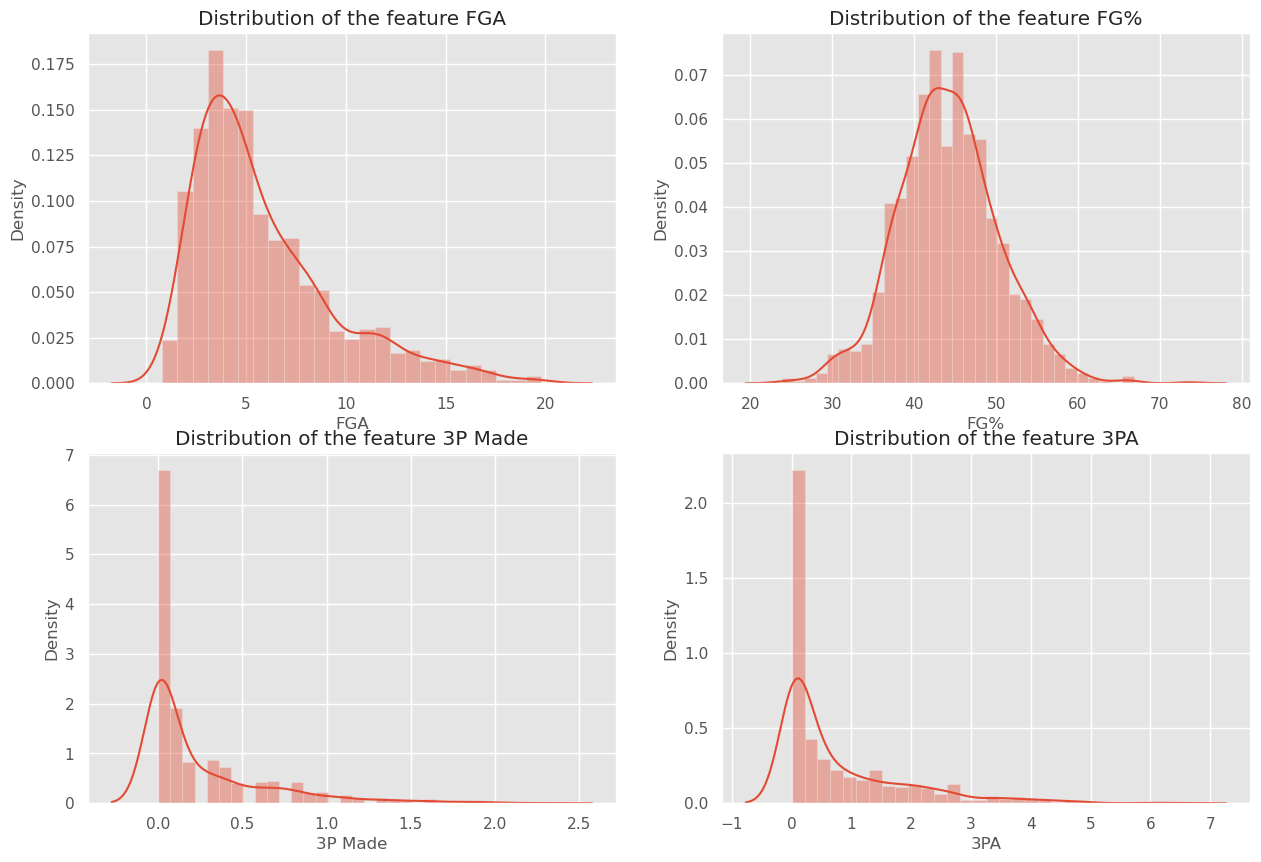

In [26]:
# Create the subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

features_to_plot=['FGA','FG%','3P Made',"3PA"]

# Plots
for count,(i, j) in enumerate(itertools.product([0, 1], repeat=2)):
    sns.distplot(data[features_to_plot[count]], ax=axes[i,j])
    axes[i,j].set_title(f'Distribution of the feature {features_to_plot[count]}')

# Display the plots
plt.show()

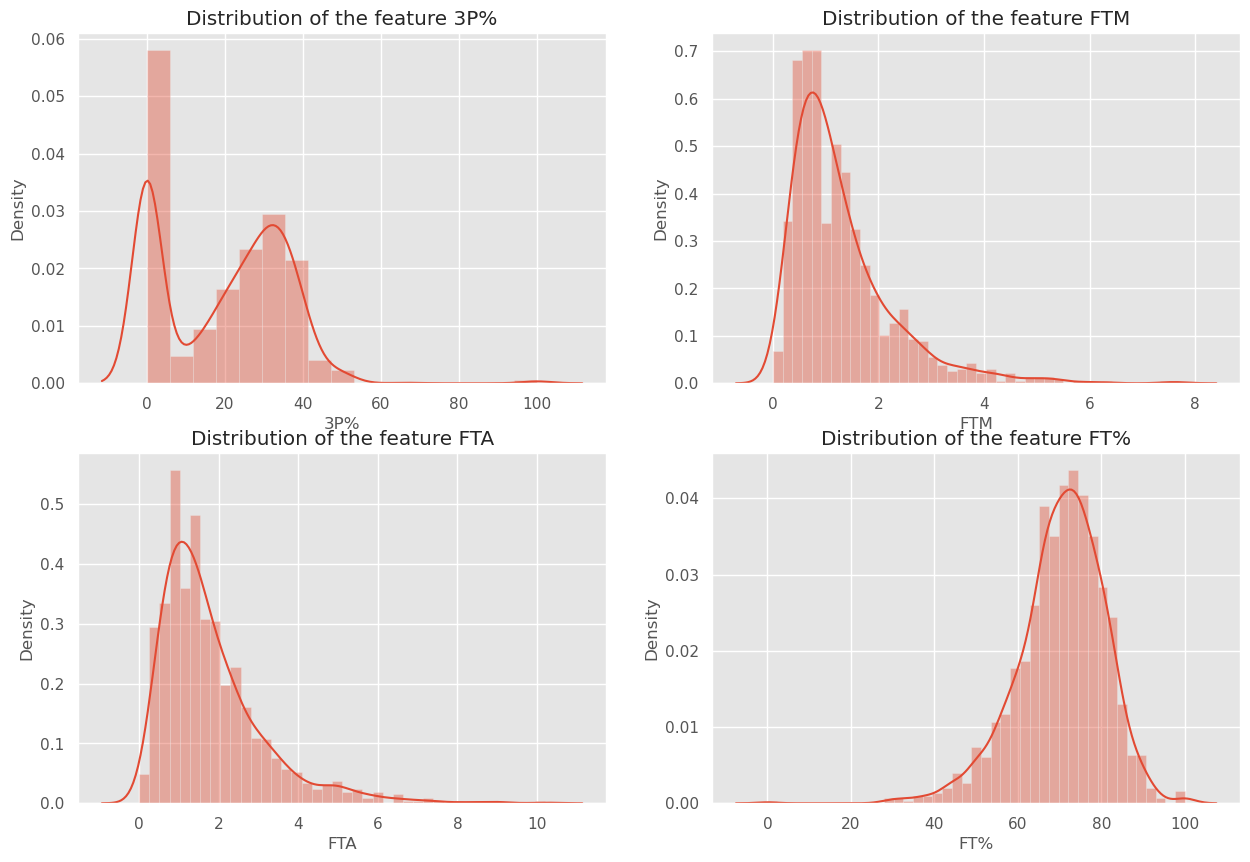

In [27]:
# Create the subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

features_to_plot=['3P%', 'FTM', 'FTA', 'FT%']

# Plots
for count,(i, j) in enumerate(itertools.product([0, 1], repeat=2)):
    sns.distplot(data[features_to_plot[count]], ax=axes[i,j])
    axes[i,j].set_title(f'Distribution of the feature {features_to_plot[count]}')

# Display the plots
plt.show()

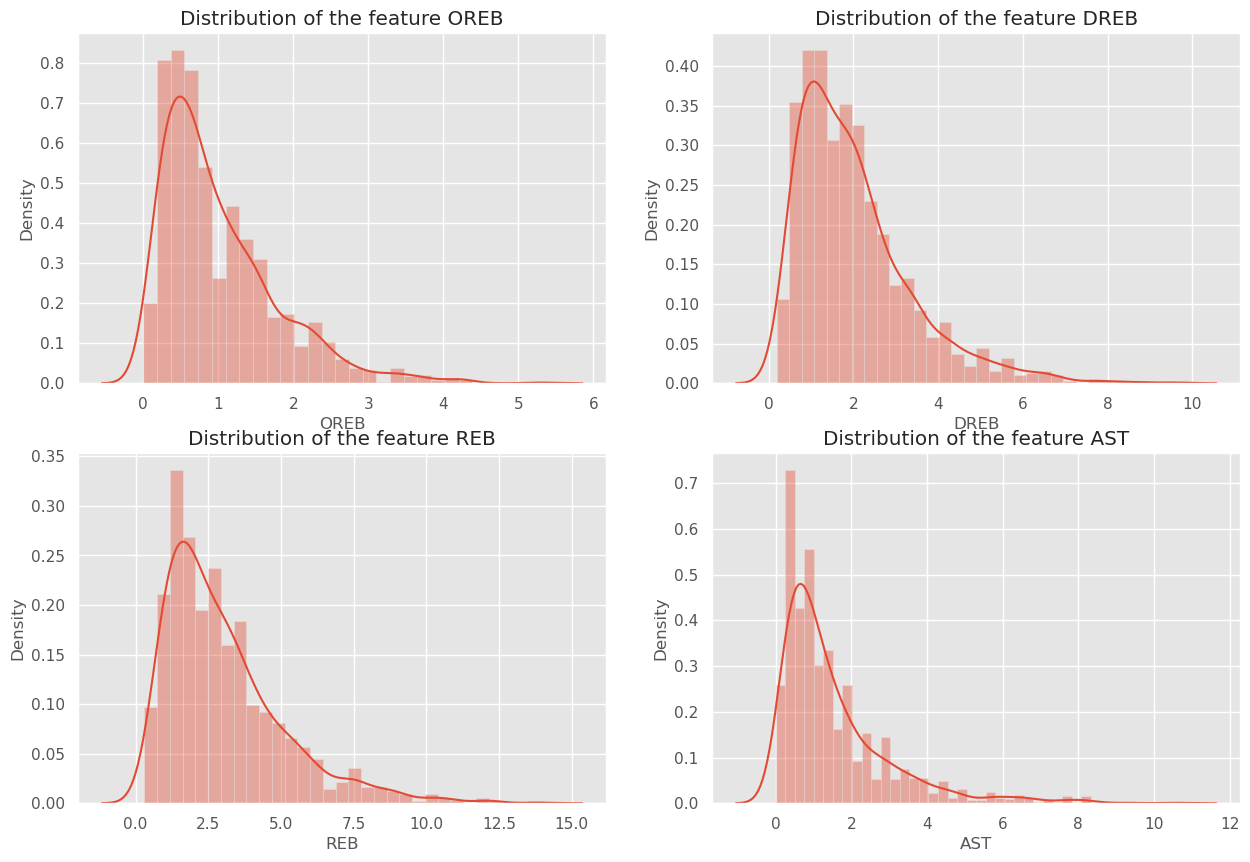

In [28]:
# Create the subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

features_to_plot=['OREB', 'DREB', 'REB', 'AST']

# Plots
for count,(i, j) in enumerate(itertools.product([0, 1], repeat=2)):
    sns.distplot(data[features_to_plot[count]], ax=axes[i,j])
    axes[i,j].set_title(f'Distribution of the feature {features_to_plot[count]}')

# Display the plots
plt.show()

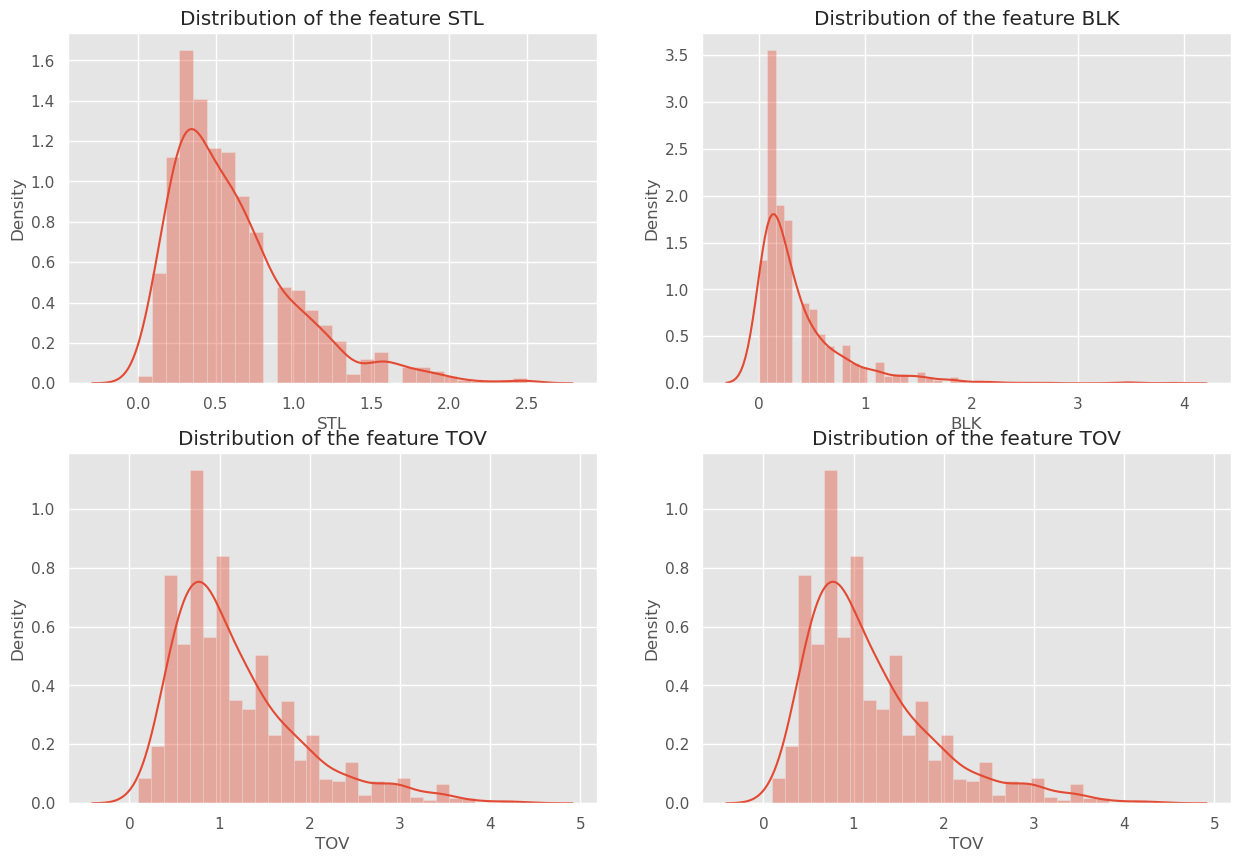

In [29]:
# Create the subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

features_to_plot=['STL', 'BLK','TOV','TOV']

# Plots
for count,(i, j) in enumerate(itertools.product([0, 1], repeat=2)):
    sns.distplot(data[features_to_plot[count]], ax=axes[i,j])
    axes[i,j].set_title(f'Distribution of the feature {features_to_plot[count]}')

# Display the plots
plt.show()

**Observations :**
* Most features do not follow a Gaussian distribution.

* Some features contain outliers, and using box plots can help visualize these atypical points.

Now, let's conduct a bivariate visual analysis by studying the relationship between each feature and the target value to identify features that might play an important role in predictions.

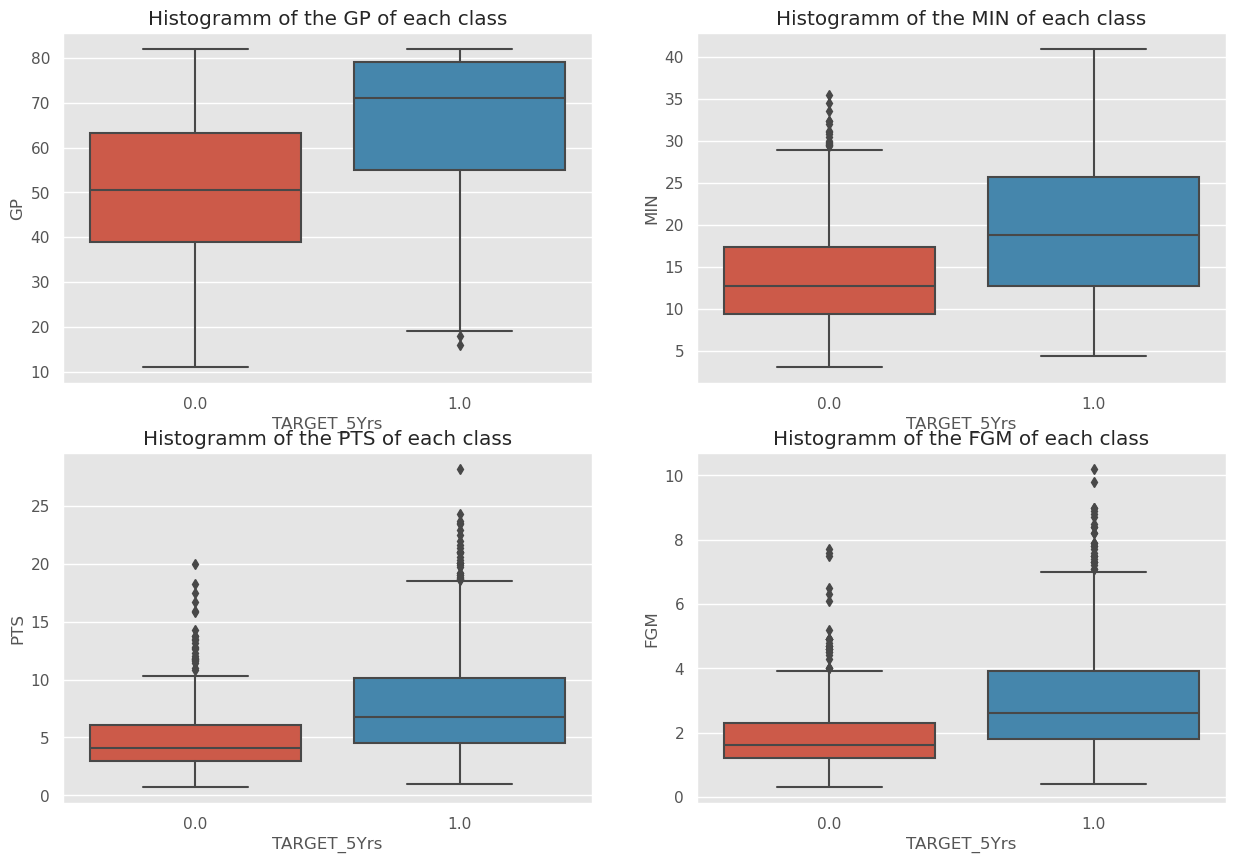

In [15]:
# Create the subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

features_to_plot=['GP','MIN','PTS',"FGM"]

# Plots
for count,(i, j) in enumerate(itertools.product([0, 1], repeat=2)):
    sns.boxplot(data,y=features_to_plot[count],x='TARGET_5Yrs', ax=axes[i,j])
    axes[i,j].set_title(f'Histogramm of the {features_to_plot[count]} of each class')

# Display the plots
plt.show()

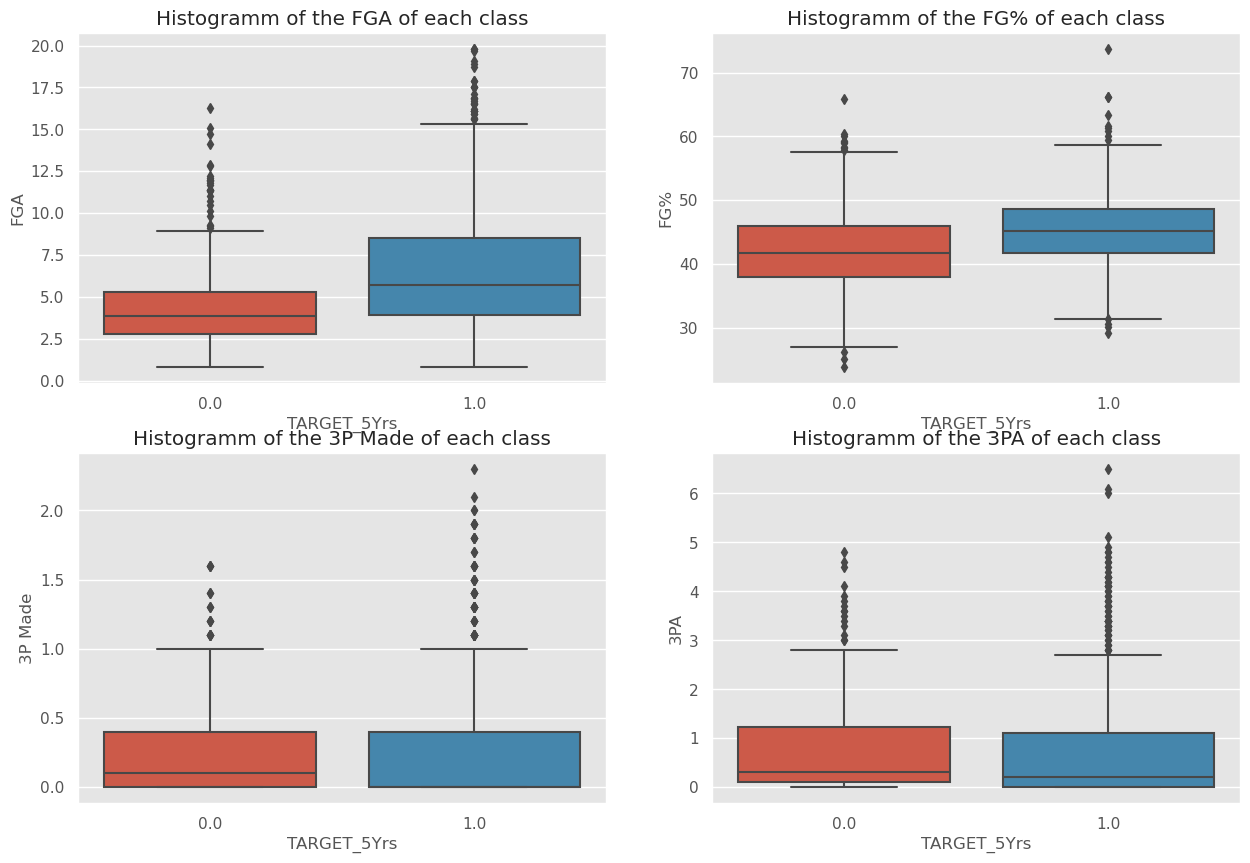

In [31]:
# Create the subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

features_to_plot=['FGA','FG%','3P Made',"3PA"]

# Plots
for count,(i, j) in enumerate(itertools.product([0, 1], repeat=2)):
    sns.boxplot(data,y=features_to_plot[count],x='TARGET_5Yrs', ax=axes[i,j])
    axes[i,j].set_title(f'Histogramm of the {features_to_plot[count]} of each class')

# Display the plots
plt.show()

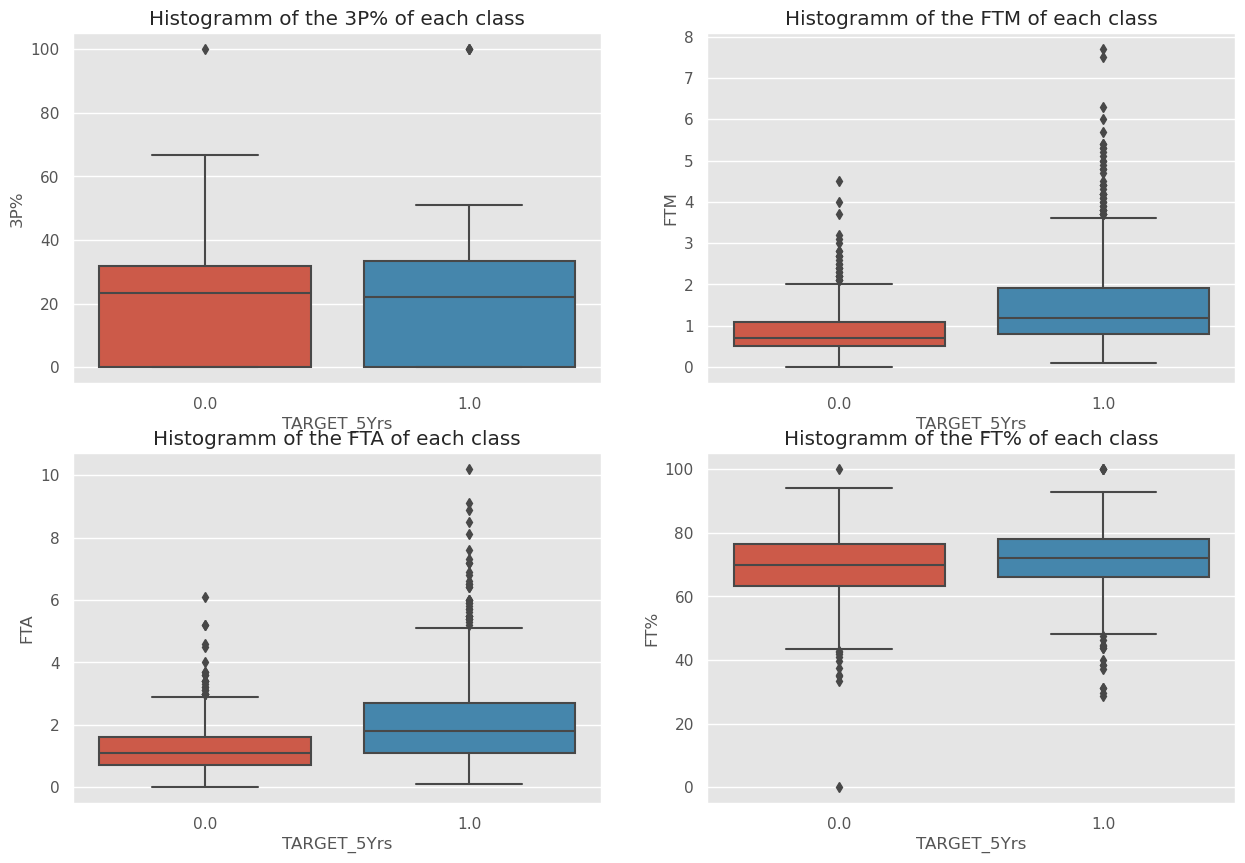

In [32]:
# Create the subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

features_to_plot=['3P%', 'FTM', 'FTA', 'FT%']

# Plots
for count,(i, j) in enumerate(itertools.product([0, 1], repeat=2)):
    sns.boxplot(data,y=features_to_plot[count],x='TARGET_5Yrs', ax=axes[i,j])
    axes[i,j].set_title(f'Histogramm of the {features_to_plot[count]} of each class')

# Display the plots
plt.show()

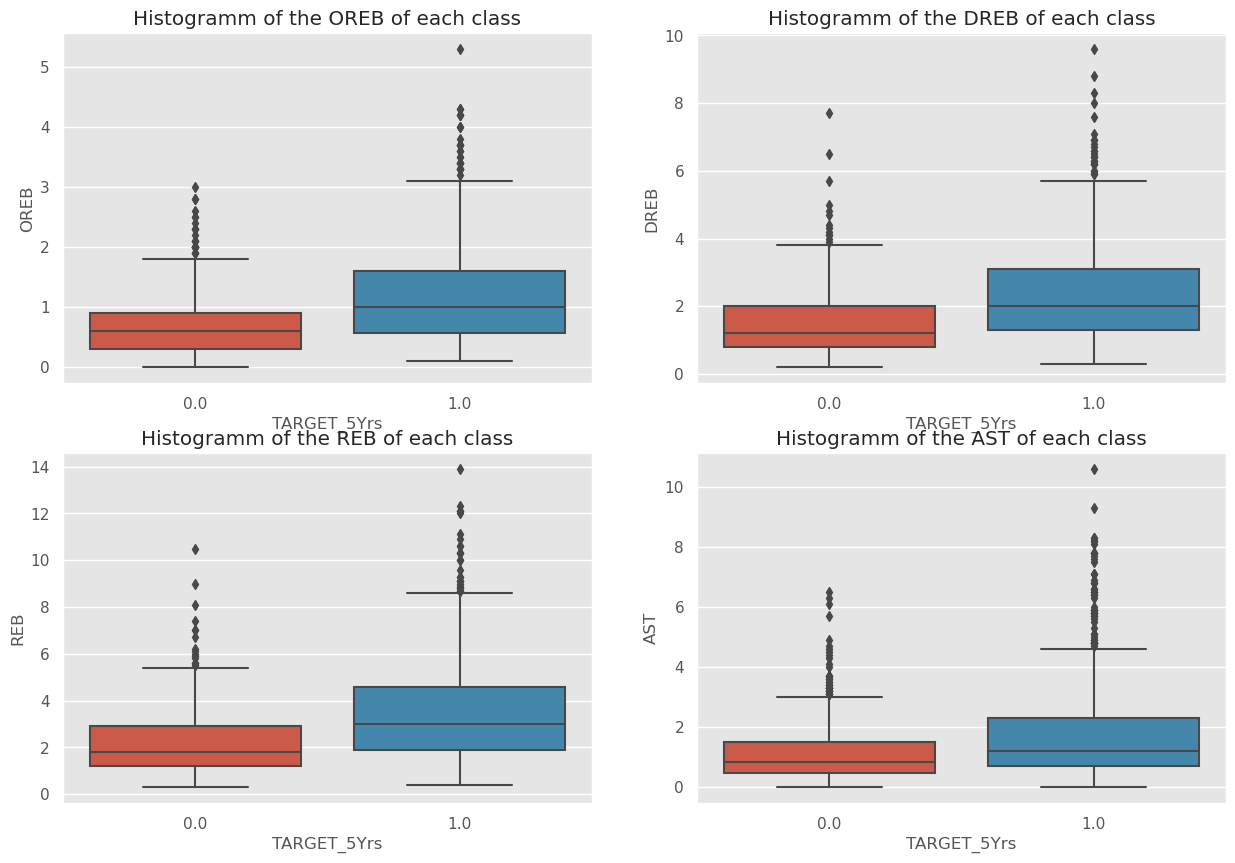

In [33]:
# Create the subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

features_to_plot=['OREB', 'DREB', 'REB', 'AST']

# Plots
for count,(i, j) in enumerate(itertools.product([0, 1], repeat=2)):
    sns.boxplot(data,y=features_to_plot[count],x='TARGET_5Yrs', ax=axes[i,j])
    axes[i,j].set_title(f'Histogramm of the {features_to_plot[count]} of each class')

# Display the plots
plt.show()

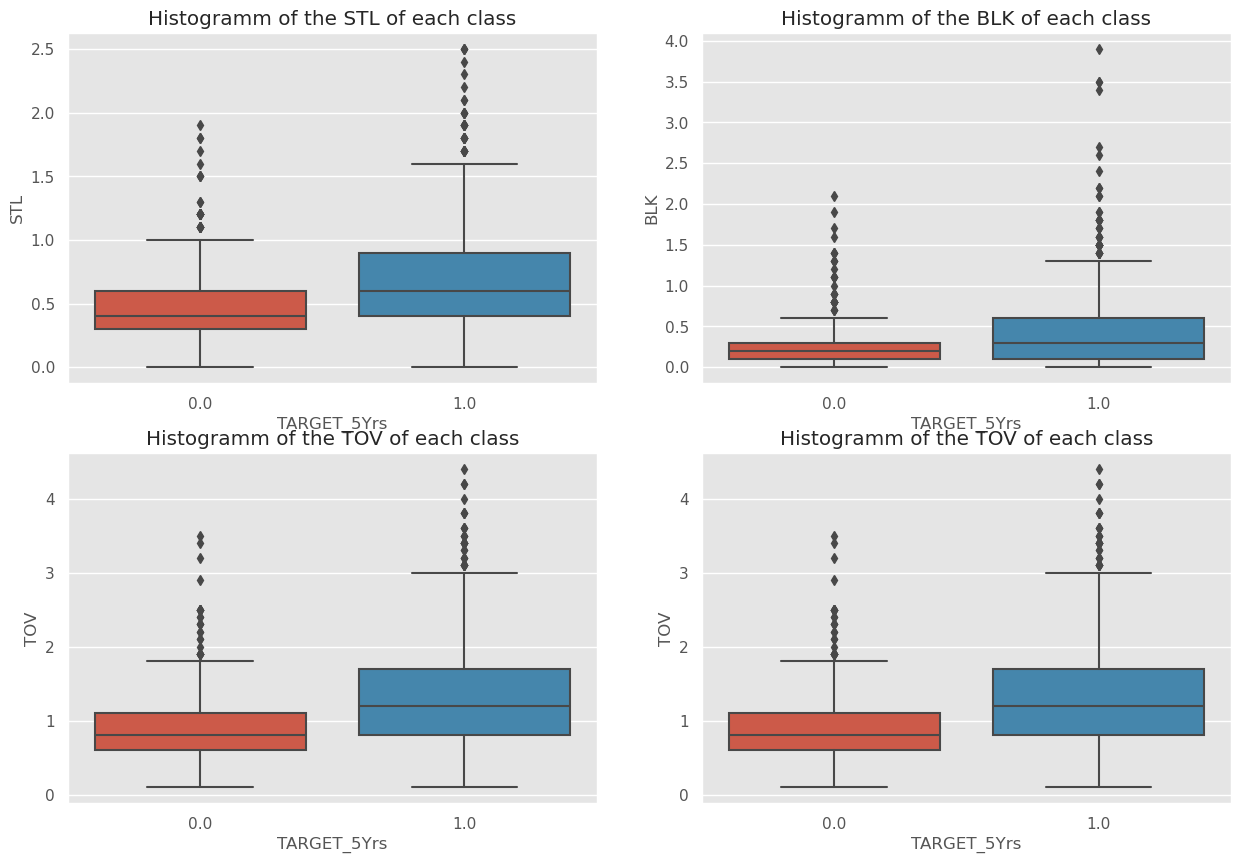

In [34]:
# Create the subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

features_to_plot=['STL', 'BLK','TOV','TOV']

# Plots
for count,(i, j) in enumerate(itertools.product([0, 1], repeat=2)):
    sns.boxplot(data,y=features_to_plot[count],x='TARGET_5Yrs', ax=axes[i,j])
    axes[i,j].set_title(f'Histogramm of the {features_to_plot[count]} of each class')

# Display the plots
plt.show()

**Observations:**

* Some features show a significant median difference between the two classes, indicating a significant separating power of the two classes. This is the case for features such as GP (games played), MIN (minutes played), and PTS (points scored). It's logical to observe that the more a player participates in more games and scores more points, the more likely they are to have a career lasting over 5 years in the NBA.

* A few features have the same median in both classes, indicating that they are not good separators. An example is the 3P% (3-point shooting percentage) feature.

* As mentioned earlier, several features exhibit outliers, for instance, TOV (turnovers) and STL (steals).

#  <span id="section_4">Modeling</span>


Let's first create our baseline model, which we'll aim to surpass later.

In [21]:
# create X and Y
X,y = data.iloc[:,:-1],data.iloc[:,-1]
del X['Name']

We will use the F1-score as a metric in this context because it offers a balance between precision and recall. We are particularly interested in precision and recall because we aim to minimize false positives (to maximize precision). This means we want to avoid investing in a player who wouldn't have a career lasting over 5 years if the model predicts them as having such a career.

On the other hand, we also aim to minimize false negatives (to maximize recall) because this signifies that we don't want to miss investing in a player who would actually have a career lasting over 5 years but the model predicted otherwise.

By using the F1-score, we take into account these two critical aspects: avoiding false positives and false negatives. 

In [22]:
#cross validation for baseline model
def print_metrics_baseline(model):
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed_value)
    cv_results = cross_val_score(model, X, y, cv = stratified_kfold, scoring = "f1")
    msg = f"baseline model metrics:   median: {np.median(cv_results)}   std: {cv_results.std()}"
    print(msg)
    return cv_results

In [23]:
#baseline model 
baseline_model = DecisionTreeClassifier(random_state=seed_value)
baseline_model_metrics = print_metrics_baseline(baseline_model)

baseline model metrics:   median: 0.6772151898734177   std: 0.028960480736869666


Now, let's build classifiers with better performance.

In [24]:
#cross validation 
def print_metrics_with_pipeline(model):
    # Create the StandardScaler for normalization
    scaler = MinMaxScaler()
    # Create the pipeline with the scaler and the classifier using make_pipeline
    pipeline = make_pipeline(scaler, model)
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed_value)
    cv_results = cross_val_score(pipeline, X, y, cv = stratified_kfold, scoring = "f1")
    msg = f" model metrics:   median: {np.median(cv_results)}   std: {cv_results.std()}"
    print(msg)
    return cv_results

In [25]:
#nous allons utiliser cinq models : lightgbm, xgboost, svc, random forest, decisiontree
# Prepare algorithms to evaluate
models = []
models.append(('XGB', xgb.XGBClassifier()))
models.append(('LGB', lgb.LGBMClassifier(random_state=seed_value)))
models.append(('RL', LogisticRegression(random_state=seed_value)))
models.append(('RF', RandomForestClassifier(random_state=seed_value)))
models.append(('SVM', SVC(random_state=seed_value)))
models.append(('LDA', LinearDiscriminantAnalysis()))
results = []
names = []
metrics_dataframe=pd.DataFrame()
for name, model in models:
    print(f"\n {name} model metrics are : ")
    cv_results = print_metrics_with_pipeline(model)
    results.append(cv_results)
    names.append(name)

#add baseline model metrics 
results.append(baseline_model_metrics)
names.append("baseline_model")


 XGB model metrics are : 
 model metrics:   median: 0.7492447129909365   std: 0.010623147302069032

 LGB model metrics are : 
 model metrics:   median: 0.7556818181818182   std: 0.021732023229205366

 RL model metrics are : 
 model metrics:   median: 0.7740112994350282   std: 0.02900149329597026

 RF model metrics are : 
 model metrics:   median: 0.7799442896935933   std: 0.021230145585095676

 SVM model metrics are : 
 model metrics:   median: 0.7720364741641338   std: 0.02373530098957081

 LDA model metrics are : 
 model metrics:   median: 0.7715133531157269   std: 0.020419935969677075


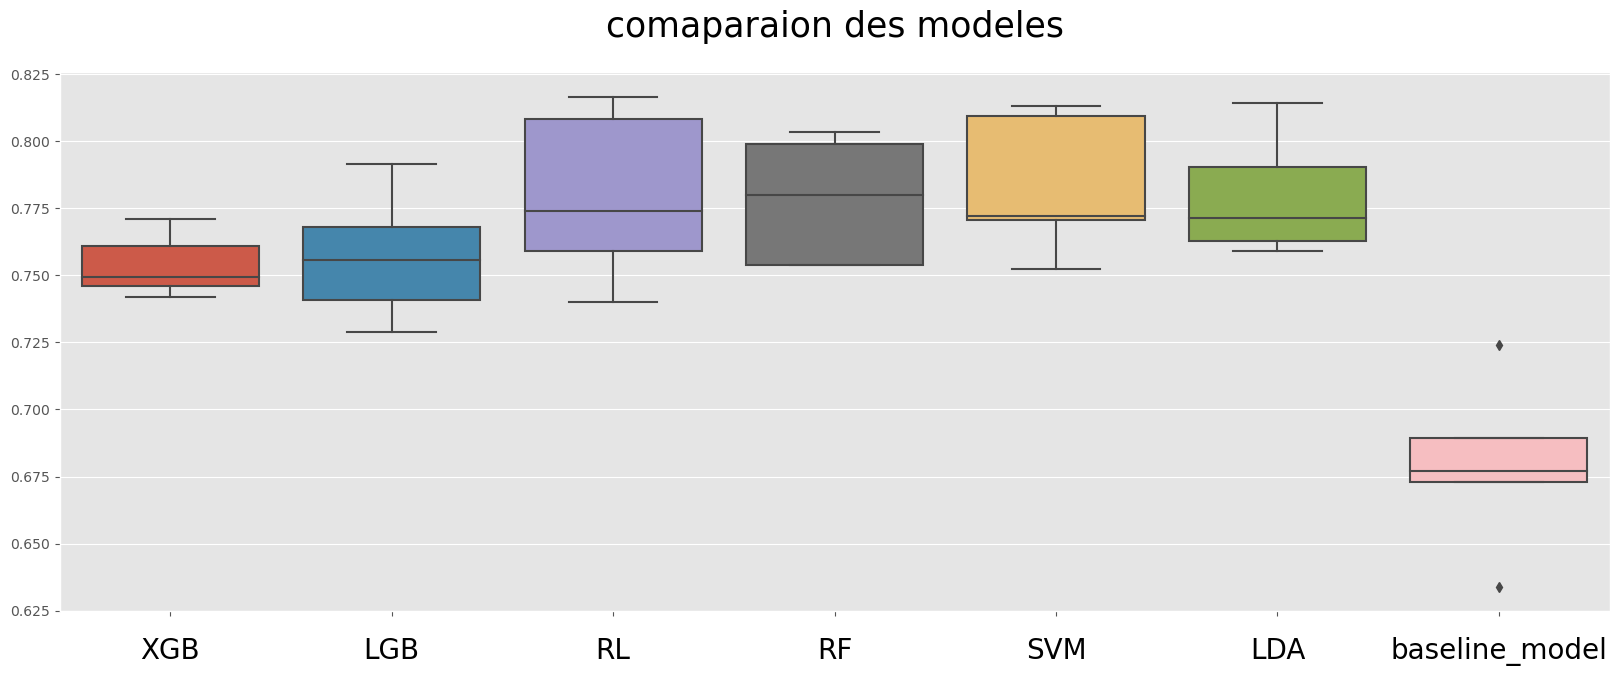

In [26]:
# Compare Algorithms
fig = plt.figure(figsize = (20,7))
fig.suptitle
ax = fig.add_subplot(111)
sns.boxplot(data = results)
ax.set_xticklabels(names, size=20, color='black', y=-0.03 )
plt.title('models comparison', fontsize=25, color = 'black', y=1.05)
plt.show()

**Observation:**

* The Random Forest model is the most performant model as it shows the highest median in the score distribution.

* The XGBoost (XGB) model has the lowest standard deviation, making it the most stable model in terms of performance.

* All models defined in this section exhibit better performance in terms of median score distribution compared to the baseline model based on decision trees.

* The logistic regression model has the highest standard deviation, making it unstable, and its performance depends on both training and test data. However, it shows the highest F1-score on training for fold 4.

Let's improve the models' performances by optimizing hyperparameters using Optuna.

In [27]:
# xgb
run_hyperparameter_optimization= False 

if run_hyperparameter_optimization : 
    def objective_xgb(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 2, 15),
            'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 1.0, 0.05),
            'n_estimators': trial.suggest_int('n_estimators', 1000, 10000, 100),
            'eta': trial.suggest_discrete_uniform('eta', 0.01, 0.1, 0.01),
            'reg_alpha': trial.suggest_int('reg_alpha', 1, 50),
            'reg_lambda': trial.suggest_int('reg_lambda', 5, 100),
            'min_child_weight': trial.suggest_int('min_child_weight', 2, 20),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        }
        scaler = MinMaxScaler()
        classifier = xgb.XGBClassifier(**params)
        # Create the pipeline with the scaler and the classifier using make_pipeline
        pipeline = make_pipeline(scaler, classifier)
        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_results = cross_val_score(pipeline, X, y, cv = stratified_kfold, scoring = "f1")
        score = np.mean(cv_results)  # 5-fold cross-validation

        return score

    study = optuna.create_study(direction='maximize')  # maximize the mean cross-validation score
    study.optimize(objective_xgb, n_trials=100)  # number of trials for optimization

    print("Best trial:")
    print("  Value: ", study.best_value)
    print("  Params: ")
    for key, value in study.best_params.items():
        print(f"    {key}: {value}")

In [22]:
xgb_best_param={'max_depth': 13,
 'subsample': 0.9,
 'n_estimators': 6400,
 'eta': 0.02,
 'reg_alpha': 21,
 'reg_lambda': 56,
 'min_child_weight': 4,
 'colsample_bytree': 0.8382773426080112}

In [47]:
# lgb
if run_hyperparameter_optimization : 
    def objective_lgb(trial):
        params = {
            "objective": "binary",
            "metric": "binary_logloss",
            "verbose": -1,
            "boosting_type": "gbdt",
            "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0),
            "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0),
            "num_leaves": trial.suggest_int("num_leaves", 2, 256),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
            'random_state':seed_value,
        }
        scaler = MinMaxScaler()
        classifier = lgb.LGBMClassifier(**params)
        # Create the pipeline with the scaler and the classifier using make_pipeline
        pipeline = make_pipeline(scaler, classifier)
        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_results = cross_val_score(pipeline, X, y, cv = stratified_kfold, scoring = "f1")
        score = np.mean(cv_results)  # 5-fold cross-validation

        return score

    study = optuna.create_study(direction='maximize')  # maximize the mean cross-validation score
    study.optimize(objective_lgb, n_trials=100)  # number of trials for optimization

    print("Best trial:")
    print("  Value: ", study.best_value)
    print("  Params: ")
    for key, value in study.best_params.items():
        print(f"    {key}: {value}")

In [23]:
lgb_best_param={'lambda_l1': 9.09361858263554,
 'lambda_l2': 5.631736889604711,
 'num_leaves': 177,
 'feature_fraction': 0.6186429488468642,
 'bagging_fraction': 0.913907641849991,
 'bagging_freq': 5,
 'min_child_samples': 48,
'random_state':seed_value,
               }



In [49]:
# lr
if run_hyperparameter_optimization : 
    def objective_lr(trial):
        params={
        "C": trial.suggest_loguniform('C', 1e-5, 100),
        "max_iter" : trial.suggest_int('max_iter', 100, 1000),
        'random_state':seed_value,
        }
        scaler = MinMaxScaler()
        classifier = LogisticRegression(**params)
        # Create the pipeline with the scaler and the classifier using make_pipeline
        pipeline = make_pipeline(scaler, classifier)
        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_results = cross_val_score(pipeline, X, y, cv = stratified_kfold, scoring = "f1")
        score = np.mean(cv_results)  # 5-fold cross-validation

        return score

    study = optuna.create_study(direction='maximize')  # maximize the mean cross-validation score
    study.optimize(objective_lr, n_trials=100)  # number of trials for optimization

    print("Best trial:")
    print("  Value: ", study.best_value)
    print("  Params: ")
    for key, value in study.best_params.items():
        print(f"    {key}: {value}")

In [24]:
lr_best_param= {'C': 32.44663293263088, 'max_iter': 701,'random_state':seed_value}


In [51]:
# rf
if run_hyperparameter_optimization : 
    def objective_rf(trial):
        params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
                'max_depth': trial.suggest_int('max_depth', 4, 50),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 150),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 60),
                'random_state':seed_value,

        }
        scaler = MinMaxScaler()
        classifier = RandomForestClassifier(**params)
        # Create the pipeline with the scaler and the classifier using make_pipeline
        pipeline = make_pipeline(scaler, classifier)
        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_results = cross_val_score(pipeline, X, y, cv = stratified_kfold, scoring = "f1")
        score = np.mean(cv_results)  # 5-fold cross-validation

        return score

    study = optuna.create_study(direction='maximize')  # maximize the mean cross-validation score
    study.optimize(objective_rf, n_trials=100)  # number of trials for optimization

    print("Best trial:")
    print("  Value: ", study.best_value)
    print("  Params: ")
    for key, value in study.best_params.items():
        print(f"    {key}: {value}")

In [26]:
rf_best_param = {'n_estimators': 185,
 'max_depth': 36,
 'min_samples_split': 126,
 'min_samples_leaf': 30,
 'random_state':seed_value,
}

In [53]:
# svc
if run_hyperparameter_optimization : 
    def objective_svc(trial):
        params={
        "C" : trial.suggest_loguniform('C', 1e-5, 100),
        "kernel" : trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        "gamma" : trial.suggest_float('gamma', 0.000001,5),
        'random_state':seed_value,
        }
        scaler = MinMaxScaler()
        classifier = SVC(**params)
        # Create the pipeline with the scaler and the classifier using make_pipeline
        pipeline = make_pipeline(scaler, classifier)
        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_results = cross_val_score(pipeline, X, y, cv = stratified_kfold, scoring = "f1")
        score = np.mean(cv_results)  # 5-fold cross-validation

        return score

    study = optuna.create_study(direction='maximize')  # maximize the mean cross-validation score
    study.optimize(objective_svc, n_trials=100)  # number of trials for optimization

    print("Best trial:")
    print("  Value: ", study.best_value)
    print("  Params: ")
    for key, value in study.best_params.items():
        print(f"    {key}: {value}")

In [27]:
svc_best_param = {'C': 0.5900129662187972, 'kernel': 'rbf', 'gamma': 3.347856946115928, 'random_state':seed_value}

In [55]:
# lr
if run_hyperparameter_optimization : 
    def objective_lda(trial):
        params={
        'solver' : trial.suggest_categorical('solver', ['lsqr', 'eigen']),
        'shrinkage' : trial.suggest_float('shrinkage', 0.0, 1.0)
        }
        scaler = MinMaxScaler()
        classifier = LinearDiscriminantAnalysis(**params)
        # Create the pipeline with the scaler and the classifier using make_pipeline
        pipeline = make_pipeline(scaler, classifier)
        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_results = cross_val_score(pipeline, X, y, cv = stratified_kfold, scoring = "f1")
        score = np.mean(cv_results)  # 5-fold cross-validation

        return score

    study = optuna.create_study(direction='maximize')  # maximize the mean cross-validation score
    study.optimize(objective_lda, n_trials=100)  # number of trials for optimization

    print("Best trial:")
    print("  Value: ", study.best_value)
    print("  Params: ")
    for key, value in study.best_params.items():
        print(f"    {key}: {value}")

In [28]:
lda_best_params={'solver': 'lsqr', 'shrinkage': 0.3685987661015801}

In [29]:
#print metrics after using optuna hyperparameter optimization

models = []
models.append(('XGB', xgb.XGBClassifier(**xgb_best_param)))
models.append(('LGB', lgb.LGBMClassifier(**lgb_best_param)))
models.append(('LR', LogisticRegression(**lr_best_param)))
models.append(('RF', RandomForestClassifier(**rf_best_param)))
models.append(('SVM', SVC(**svc_best_param)))
models.append(("LDA",LinearDiscriminantAnalysis(**lda_best_params)))
results = []
names = []
for name, model in models:
    print(f"\n les metriques du modele {name} sont : ")
    cv_results = print_metrics_with_pipeline(model)
    results.append(cv_results)
    names.append(name)

#add baseline model metrics 
results.append(baseline_model_metrics)
names.append("baseline_model")


 les metriques du modele XGB sont : 
 model metrics:   median: 0.7838616714697406   std: 0.02400151078160851

 les metriques du modele LGB sont : 
[LightGBM] [Warning] lambda_l1 is set=9.09361858263554, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.09361858263554
[LightGBM] [Warning] bagging_fraction is set=0.913907641849991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.913907641849991
[LightGBM] [Warning] feature_fraction is set=0.6186429488468642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6186429488468642
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=5.631736889604711, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.631736889604711
[LightGBM] [Warning] lambda_l1 is set=9.09361858263554, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.09361858263554
[LightGBM] [Warning] bagging_fraction is set=0.91390764

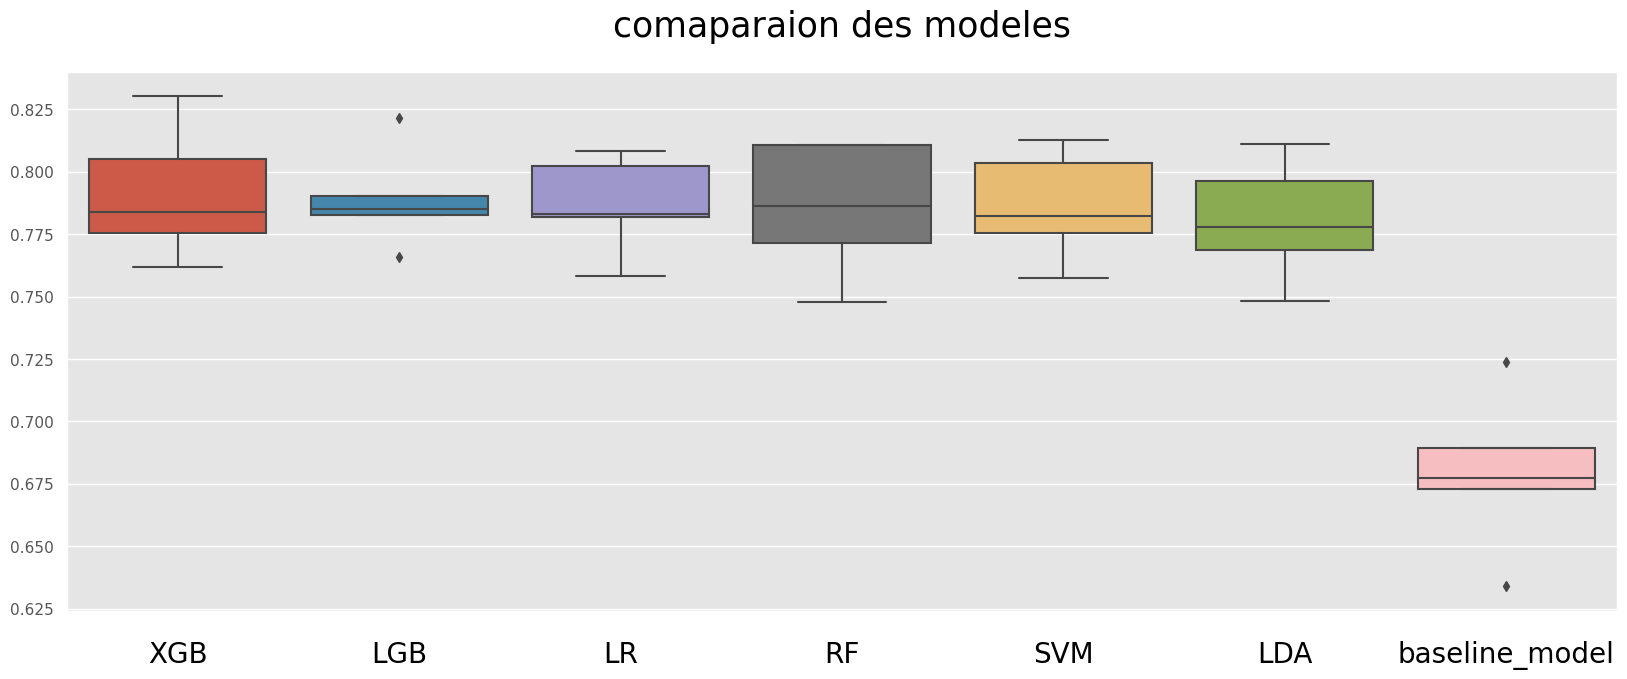

In [30]:
# Compare Algorithms
fig = plt.figure(figsize = (20,7))
fig.suptitle
ax = fig.add_subplot(111)
sns.boxplot(data = results)
ax.set_xticklabels(names, size=20, color='black', y=-0.03 )
plt.title('modeles comparison', fontsize=25, color = 'black', y=1.05)
plt.show()

**Observations:**

* Thanks to hyperparameter optimization, the median of the score distribution has been improved for all the models studied.

* The optimized Random Forest model has proven to be the most performant, with the highest median in the score distribution.

Now, we'll attempt to ensemble the optimized models into a single model to see if we can achieve an even better model through ensemble learning.

In [59]:
#voting classifier

voting_classifier = VotingClassifier(estimators=[
                                     ('XGB', xgb.XGBClassifier(**xgb_best_param)), 
                                     ('LGB', lgb.LGBMClassifier(**lgb_best_param)), 
                                     ('LR', LogisticRegression(**lr_best_param)),
                                     ('RF', RandomForestClassifier(**rf_best_param)),
                                      ('SVM', SVC(**svc_best_param))], 
                                     voting='hard')

voting_classifier_cv_results = print_metrics_with_pipeline(voting_classifier)

[LightGBM] [Warning] lambda_l1 is set=9.09361858263554, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.09361858263554
[LightGBM] [Warning] bagging_fraction is set=0.913907641849991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.913907641849991
[LightGBM] [Warning] feature_fraction is set=0.6186429488468642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6186429488468642
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=5.631736889604711, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.631736889604711
[LightGBM] [Warning] lambda_l1 is set=9.09361858263554, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.09361858263554
[LightGBM] [Warning] bagging_fraction is set=0.913907641849991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.913907641849991
[LightGBM] [Warning] feature_fraction is set=0.61864294884

In [60]:
results.append(voting_classifier_cv_results)
names.append('voting_classifier')

In [61]:
#stacking model
# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('XGB', xgb.XGBClassifier(**xgb_best_param)))
    level0.append(('LGB', lgb.LGBMClassifier(**lgb_best_param)))
    level0.append(('RF', RandomForestClassifier(**rf_best_param)))
    level0.append(('SVM', SVC(**svc_best_param)))
    level0.append(("LDA",LinearDiscriminantAnalysis(**lda_best_params)))
    # define meta learner model
    level1 = LogisticRegression()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1)
    return model

stacking_model_cv_results = print_metrics_with_pipeline(get_stacking())

[LightGBM] [Warning] lambda_l1 is set=9.09361858263554, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.09361858263554
[LightGBM] [Warning] bagging_fraction is set=0.913907641849991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.913907641849991
[LightGBM] [Warning] feature_fraction is set=0.6186429488468642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6186429488468642
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=5.631736889604711, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.631736889604711
[LightGBM] [Warning] lambda_l1 is set=9.09361858263554, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.09361858263554
[LightGBM] [Warning] bagging_fraction is set=0.913907641849991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.913907641849991
[LightGBM] [Warning] feature_fraction is set=0.61864294884

In [62]:
results.append(stacking_model_cv_results)
names.append('stacking_classifier')

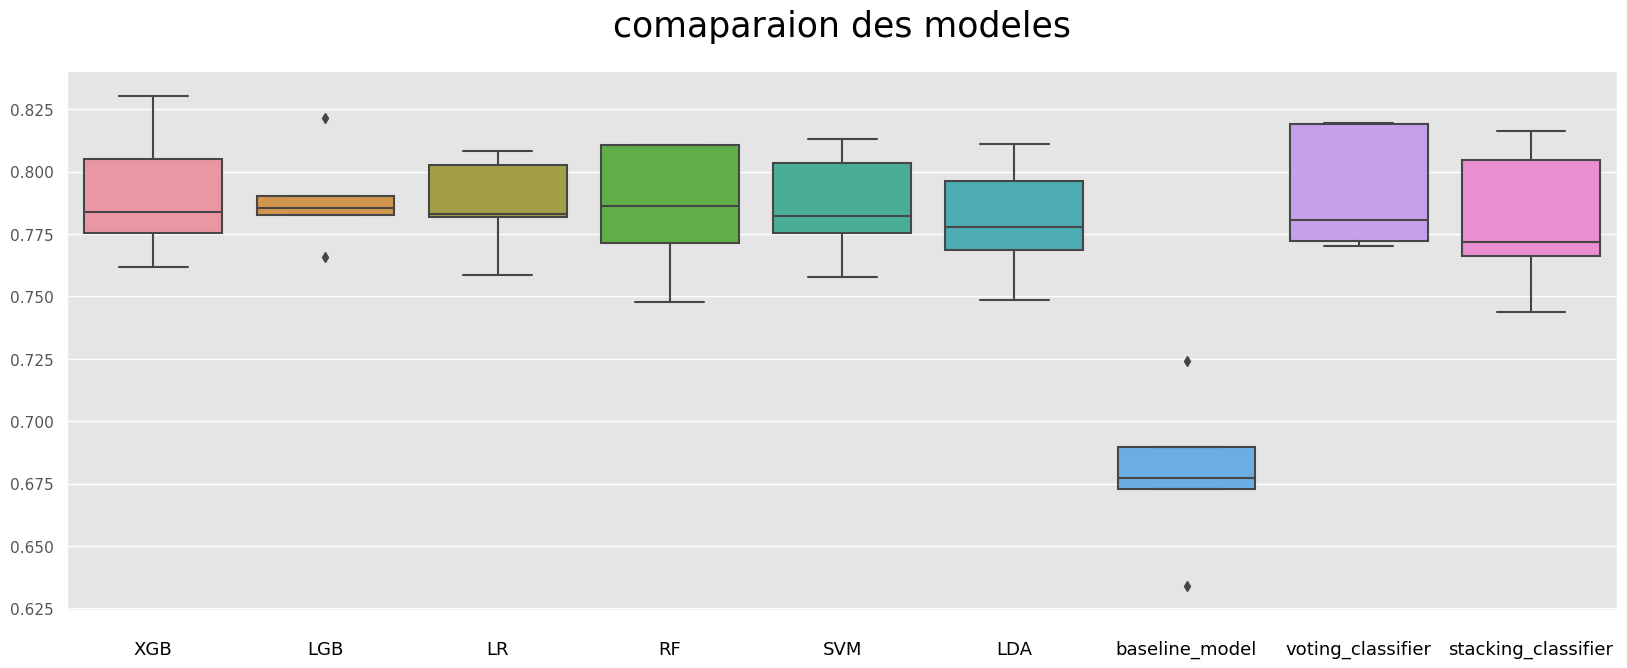

In [63]:
# Compare Algorithms
fig = plt.figure(figsize = (20,7))
fig.suptitle
ax = fig.add_subplot(111)
sns.boxplot(data = results)
ax.set_xticklabels(names, size=13, color='black', y=-0.03 )
plt.title('modeles comparison', fontsize=25, color = 'black', y=1.05)
plt.show()

**Conclusion:** The optimized Random Forest model is clearly the most performant among all evaluated models, displaying the highest median in the score distribution.

#  <span id="section_1">Conclusion</span>


As we've previously concluded, the optimized Random Forest model is the most performant. Now, we'll create a comprehensive class based on this model, which we'll later use to integrate it into an API.

In [31]:
class FinalModel:
    def __init__(self, data, hyperparameters= None, seed=42):
        if hyperparameters is not None:
            self.hyperparameters = hyperparameters
        else:
            self.hyperparameters = {
                "n_estimators": 185,
                "max_depth": 36,
                "min_samples_split": 126,
                "min_samples_leaf": 30,
                "random_state": seed,
            }
        self.pipeline = None
        self.data=data

    def get_model(self):
        model = RandomForestClassifier(**self.hyperparameters)
        return model

    def clean_data(self):
        if 'Name' in self.data.columns:
            del self.data['Name']

    def train_pipeline_and_save(self, file_path):
        # Create the pipeline with scaler and model
        pipeline = Pipeline(
            [
                ("scaler", MinMaxScaler()),  # Scaling step
                ("model", self.get_model()),  # Model step
            ]
        )
        #clean data
        self.clean_data()
        # calculate X and y
        X, y = self.data.iloc[:, :-1], self.data.iloc[:, -1]
        # Train the pipeline
        pipeline.fit(X, y)
        # save it
        dump(pipeline, file_path)

    def load_pipeline(self, file_path):
        loaded_pipeline = load(file_path)
        self.pipeline = loaded_pipeline

    def predict(self, x):
        if self.pipeline is not None:
            return self.pipeline.predict(x)
        else:
            return {"No Pipeline Founded"}


In [32]:
#initiate class object
final_model=FinalModel(data=data)

In [33]:
#train on all data
file_path="./model_pipeline.joblib"
final_model.train_pipeline_and_save(file_path=file_path)

In [34]:
#load pipeline trained
final_model.load_pipeline(file_path=file_path)

In [35]:
#prediction example
x = data[:1].iloc[:,0:-1]
pred = final_model.predict(x)[0]
{"prediction": pred }

{'prediction': 1.0}